# Neutrino oscillation with CP violation- Figure 5

## Importing standard Qiskit modules

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# suppress warnings
import warnings
warnings.filterwarnings('ignore')
# load IBMQ Account data

provider = IBMQ.load_account()
# Get backend for experiment
provider = IBMProvider()
jakarta = provider.get_backend('ibmq_jakarta')


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/tmp/ipykernel_59/3471808702.py:8: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


## Importing Qiskit pulse library
- Get properties of imbq_jarkata: dt, frequency, anhamornicity
- Define funciton to retrieve data from a job that has already run.

In [2]:
from qiskit import pulse
import numpy as np
pi = np.pi
from qiskit.pulse.library import Gaussian
from qiskit.pulse.library import Drag

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import Waveform
from qiskit.tools.monitor import job_monitor
from qiskit.pulse import library

import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline
import matplotlib.pyplot as plt

from qiskit import IBMQ

backend = jakarta
backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt = backend_config.dt

assert backend_config.open_pulse, "Backend doesn't support Pulse"

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 512*2
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
cont_chan = pulse.ControlChannel(qubit)

def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result() # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*4        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

default_anharmonicity = backend_properties.qubits[qubit][3].value # Default anharmonicity in GHz
anh = default_anharmonicity*GHz
f12 = f01+anh
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")
print(f"Qubit {qubit} has an anharm frequency of {f12/ GHz} GHz.")

cal_qubit_freq = default_qubit_freq

drive_duration = drive_samples
meas = inst_sched_map.get('measure', qubits=[qubit])

Qubit 0 has an estimated frequency of 5.2365434018244965 GHz.
Qubit 0 has an anharm frequency of 4.8966634018244966 GHz.


## Importing Qiskit pulse tools and Ignis discriminator fitter tools

In [3]:
# Qiskit pulse
from qiskit.pulse import (MemorySlot, Acquire, DriveChannel, Schedule, Waveform, 
                          InstructionScheduleMap, Play, MeasureChannel, AcquireChannel)
from qiskit.pulse.library import Gaussian
from qiskit.qobj.utils import MeasLevel, MeasReturnType
from qiskit.scheduler import measure_all
from qiskit.visualization.pulse.qcstyle import SchedStyle

# Ignis discriminator fitter tools
from sklearn.svm import SVC
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, MeasurementFilter
from qiskit.ignis.measurement.discriminator.filters import DiscriminationFilter
from qiskit.ignis.measurement.discriminator.iq_discriminators import SklearnIQDiscriminator
from scipy import interpolate, stats
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
config = backend.configuration()
defaults = backend.defaults()
inst_map = defaults.instruction_schedule_map
style = SchedStyle(figsize=(16, 5))  # schedule style plotting
default_qubit_freq = defaults.qubit_freq_est[0] # Default qubit frequency in Hz. 
xp = inst_map.get('x', (0,)).instructions[0][1].pulse
d0 = DriveChannel(0)
dt = config.dt

In [6]:
job = backend.retrieve_job('629dd3fee66b1830084d25f7')
job.status()
# job.queue_info()

<JobStatus.DONE: 'job has successfully run'>

In [4]:
xp

Drag(duration=160, amp=(0.20003104249089076+0j), sigma=40, beta=-0.9640752024969168, name='Xp_d0')

## Import plotting tools

In [7]:
import sys
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import SchedStyle

# import fitting
# import plotting

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Import fitting tools

In [4]:
from qiskit.circuit import Parameter  # This is Parameter Class for variable parameters.
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit
def lorenz(x, a, q_freq, b, c):
     return (a / np.pi) * (b / ((x - q_freq)**2 + b**2)) + c
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)
scale_factor = 1e-14
# Rabi experiment parameters
num_rabi_points = 100

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = -0.51
drive_amp_max = 0.51
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)


In [5]:
import pandas as pd
import numpy as np

import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit_experiments.calibration_management.calibrations import Calibrations

from qiskit import IBMQ, schedule

## Define sideband modulation 
## Define measurement pulse by duration and amplitude

In [6]:
def add_modulation(pulse, freq: float, dt: float, scale: float = 1.) -> Waveform:
    """
    Add a modulation to the pulse.
    
    Args:
        samples: A list of AWG samples to modulate.
        freq: The frequency of the modulation to add to samples.
        dt: The cycle time.
        scale: a factor to scale the samples.
        
    Returns: SamplePulse with the added modulation.
    """
    
    if not isinstance(pulse, Waveform):
        samples = pulse.get_waveform().samples
    else:
        samples = pulse.samples
    
    modulated_samples = []
    for i, amp in enumerate(samples):
        modulated_samples.append(scale * amp * np.exp(2.0j*np.pi*freq*i*dt))
    
    return Waveform(modulated_samples)

measurement_duration_us = 4
measurement_amp = 0.91
measurement_sigma_us = 0.5  # Width of the gaussian part of the rise and fall in us
measurement_risefall_us = (
        0.1  # Truncating parameter: how many samples to dedicate to the risefall
    )
measurement_sigma = get_closest_multiple_of_16(measurement_sigma_us * 1e-6 / dt)
measurement_risefall = get_closest_multiple_of_16(
        measurement_risefall_us * 1e-6 / dt
    )
measurement_duration = get_closest_multiple_of_16(
        measurement_duration_us * 1e-6 / dt
    )
calibrated_measurement_pulse = pulse_lib.gaussian_square(
        duration=measurement_duration,
        sigma=measurement_sigma,
        amp=measurement_amp,
        risefall=measurement_risefall,
        name="measurement_pulse",
)

# Add a measurement stimulus on the measure channel pulse to trigger readout
calibrated_measure_schedule = pulse.Play(calibrated_measurement_pulse, meas_chan)

# Trigger data acquisition, and store measured values into respective memory slots
calibrated_measure_schedule += pulse.Acquire(
        calibrated_measurement_pulse.duration,
        pulse.AcquireChannel(backend_config.meas_map[meas_map_idx][0]),
        pulse.MemorySlot(backend_config.meas_map[meas_map_idx][0]),
)
meas_freq_shift = -0.075e6
meas_pulse= add_modulation(calibrated_measurement_pulse, meas_freq_shift, dt, scale=1)

meas_sched = Schedule(name='meas %f' % meas_freq_shift)
meas_sched += Play(meas_pulse, MeasureChannel(0))
meas_sched += Acquire(len(meas_pulse.samples), AcquireChannel(0), MemorySlot(0))

# Rerun Rabi 12 each time to get best ampitulde of pi-pulse

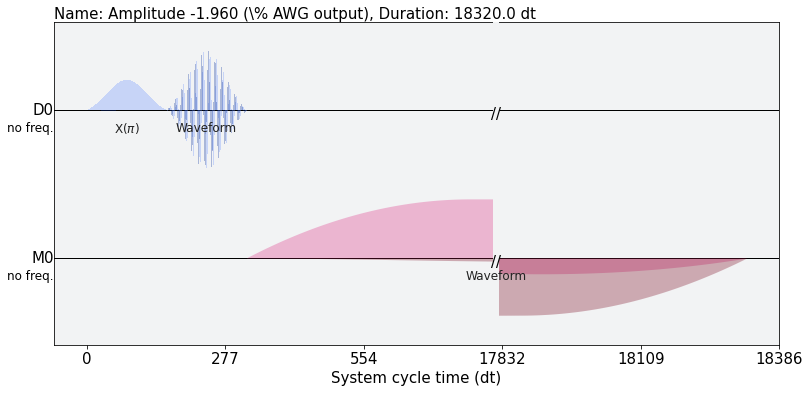

In [11]:
xp12_scales = np.linspace(-2, 2, 200)

schedules = []
for amp in xp12_scales:
    sched = Schedule(name='Amplitude {:.3f} (\\% AWG output)'.format(amp))
    
    x12add = add_modulation(xp, anh, dt,scale = amp)
    
    sched += Play(xp, d0)
    sched += Play(x12add, d0)
    sched += meas_sched << sched.duration
    
    schedules.append(sched)
schedules[2].draw()

In [19]:
qobj = assemble(schedules, backend, meas_level=1, 
                meas_return=MeasReturnType.AVERAGE,
                shots=1024*4)

In [20]:
job = backend.run(qobj)
job.job_id()
print(job.job_id())
job_monitor(job)
job.status()

629c5483a70e3369a0609b1f
Job Status: job has successfully run


<JobStatus.DONE: 'job has successfully run'>

In [21]:
def amp_func(x, a, b, c):
    """Function used to fit the amplitude scan."""
    return a*np.cos(np.pi*x/b)+c
signal = np.real(np.array(get_job_data(job, True, 0, 1e-15)))

popt, pcov = curve_fit(amp_func, xp12_scales, signal, [0.8, 1.0, 0.5])
xp12_scale = abs(popt[1])
xp12_scale 

0.6899742444328145

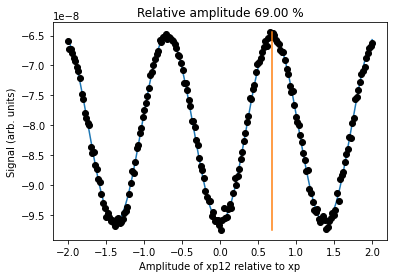

In [22]:
fig = plt.figure()
plt.plot(xp12_scales, amp_func(xp12_scales, *popt))
plt.plot(xp12_scales, signal, 'ok')
plt.plot([xp12_scale]*2, [min(signal), max(signal)])
plt.xlabel('Amplitude of xp12 relative to xp')
plt.ylabel('Signal (arb. units)')
plt.title('Relative amplitude %.2f %%' % (xp12_scale*100));

Rabi Pi-amplitude X12 gate

In [14]:
xp12_scale=0.6894804997011431

## Measurement schedule
To correct for random drifting in IBM’s hardware, the first three circuits of any runs are designed for calibration. Their results constitute an inverse matrix for the mitigation protocol.

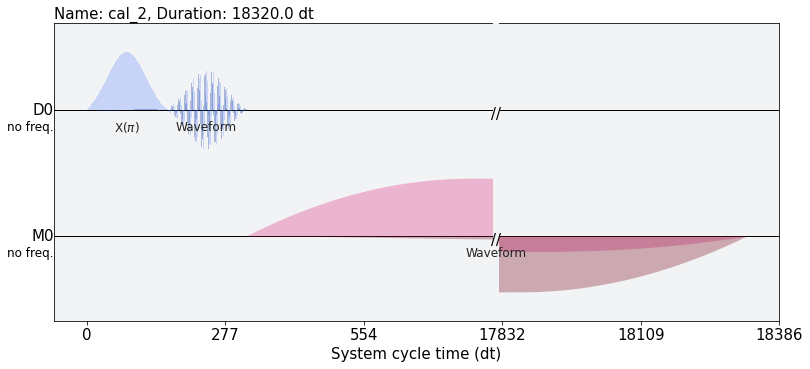

In [15]:
schedules_cal = []
# meas_sched = meas
d0 = drive_chan
cal0 = Schedule(name='cal_0')
cal0 += meas_sched << cal0.duration
schedules_cal.append(cal0)

cal1 = Schedule(name='cal_1')
cal1 += Play(xp, d0) << cal1.duration
cal1 += meas_sched << cal1.duration
schedules_cal.append(cal1)

# Create the calibrated pi-pulse between |1> and |2>
xp12add = add_modulation(xp, anh, dt,scale = xp12_scale)
cal2 = Schedule(name='cal_2')
cal2 += Play(xp, d0)
# cal2 += pulse.ShiftFrequency(anh, drive_chan)
cal2 += Play(xp12add, d0)
cal2 += meas_sched << cal2.duration

schedules_cal.append(cal2)
schedules_cal[2].draw()

# Run finetune experiment for Gaussian pulse to find better pi amp01  ([Qiskit experiment](https://qiskit.org/documentation/experiments/tutorials/fine_calibrations.html))
Here we use an approximation by setting amp=xp.amp*theta/pi 

## Define pulse gates

In [19]:
#Rx01 Rx12
def rx01(theta):
    pulse.play(pulse.Drag(duration=160, amp=xp.amp*theta/pi, sigma=40, beta=0), drive_chan) 
    return rx01
def rx12(theta):
    pulse.play(add_modulation(xp, anh, dt,scale = xp12_scale*theta/pi), drive_chan) 
    return rx12

## Define qutrit gates and neutrino mixing parameters

In [20]:
pi = np.pi
cos = np.cos
sin = np.sin
exp = np.exp
sqrt = np.sqrt
def Rx_01(theta):
    Rx_01 = np.array([[cos(theta/2)     , -1j*sin(theta/2) , 0],
                      [-1j*sin(theta/2) , cos(theta/2)     , 0],
                      [0                , 0                , 1]])
    return Rx_01

def Rx_12(theta):
    Rx_12 = np.array([[1 , 0                , 0               ],
                      [0 , cos(theta/2)     , -1j*sin(theta/2)],
                      [0 , -1j*sin(theta/2) , cos(theta/2)    ]])
    return Rx_12

def Ry_01(theta):
    Ry_01 = np.array([[cos(theta/2) , -sin(theta/2) , 0],
                      [sin(theta/2) , cos(theta/2)  , 0],
                      [0            , 0             , 1]])
    return Ry_01

def Ry_12(theta):
    Ry_12 = np.array([[1 , 0            , 0            ],
                      [0 , cos(theta/2) , -sin(theta/2)],
                      [0 , sin(theta/2) , cos(theta/2) ]])
    return Ry_12

def Rz_01(theta):
    Rz_01 = np.array([[exp((-1j*theta)/2) , 0                 , 0],
                      [0                  , exp((1j*theta)/2) , 0],
                      [0                  , 0                 , 1]])
    return Rz_01

def Rz_12(theta):
    Rz_12 = np.array([[1 , 0                  , 0                ],
                      [0 , exp((-1j*theta)/2) , 0                ],
                      [0 , 0                  , exp((1j*theta)/2)]])
    return Rz_12

t12 = np.radians(33.45)
t23 = np.radians(42.1)
t13 = np.radians(8.62)
D21 = 7.42*1e-5
D31 = 2.510*1e-3 #
D32 = D31-D21 ###
# Now gate simulator
c12 = cos(t12)
s12 = sin(t12)
c13 = cos(t13)
s13 = sin(t13)
c23 = cos(t23)
s23 = sin(t23)

- Function to covert vacuum mixing parameters to matter mixng parameters
- Set a=0 one gets vacuum parameters

In [21]:
def parameters(a):
    Dee = c12**2*D31+s12**2*D32
    Dee_t = Dee*sqrt((cos(2*t13)-a/Dee)**2+sin(2*t13)**2)
    s13t_sq = 0.5*(1-(Dee*cos(2*t13)-a)/Dee_t)
    t13t = np.arcsin(sqrt(s13t_sq))
    a12 = 0.5*(a+Dee-Dee_t)
    D21t = D21*sqrt((cos(2*t12)-a12/D21)**2 + cos(t13-t13t)**2*sin(2*t12)**2)
    s12t_sq = 0.5*(1-(D21*cos(2*t12)-a12)/D21t)
    t12t = np.arcsin(sqrt(s12t_sq))
    D31t = D31+a/4+0.5*(D21t-D21)+0.75*(Dee_t-Dee)
    t23t = t23
    return t23t,t13t, t12t, D21t, D31t
def NeudCPMatter(dCP, initial, matter, sim):
    try:
        if initial == 'e':
            flavor_initial = [1,0,0]
        elif initial == 'm':
            flavor_initial = [0,1,0]
        elif initial == 't':
            flavor_initial = [0,0,1]
    except:
        print('start from e, m, t only')
    t23m, t13m, t12m, D21m, D31m = parameters(matter)
    dCPm = dCP
    c12m = cos(t12m)
    s12m = sin(t12m)
    c13m = cos(t13m)
    s13m = sin(t13m)
    c23m = cos(t23m)
    s23m = sin(t23m)
    
    Um = np.array([[c12m*c13m            , s12m*c13m             , s13m*exp(-1j*dCP)],
               [-s12m*c23m-c12m*s23m*s13m*exp(1j*dCP), c12m*c23m-s12m*s23m*s13m*exp(1j*dCP) , s23m*c13m],
               [s12m*s23m-c12m*c23m*s13m*exp(1j*dCP) , -c12m*s23m-s12m*c23m*s13m*exp(1j*dCP), c23m*c13m]])
    iUm = Um.conj().T

    e_survival1a = []
    mu_survival1a = []
    tau_survival1a = []
    
    for E in sim:
        l = L
        evolmatrix = np.diag([1, exp(-1j*D21m*l/(2*E)), exp(-1j*l*D31m/(2*E))])
        flavor = Um@evolmatrix@iUm@flavor_initial
        e_survival1a.append(np.absolute(flavor[0])**2)
        mu_survival1a.append(np.absolute(flavor[1])**2)
        tau_survival1a.append(np.absolute(flavor[2])**2)
    return e_survival1a, mu_survival1a, tau_survival1a

In [22]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import pandas as pd
import seaborn as sns
#bodacious colors
colors=sns.color_palette("rocket",3)
#Ram's colors, if desired
seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608', '#0193b0', '#9c5300', '#949c01', '#7104b5']
#            0sangre,   1neptune,  2pumpkin,  3clover,   4denim,    5cocoa,    6cumin,    7berry

## The pulse schedules below implement this gate decomposition PMNS (with CP violation)
Measuring this state yields the probability distribution of an oscillating neutrino with CP violation, as the PMNS mechanism dictates.

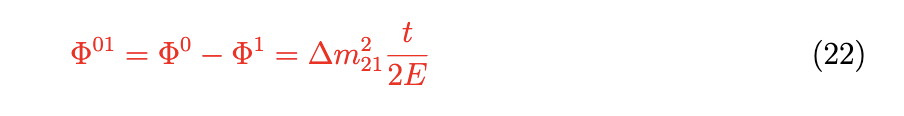
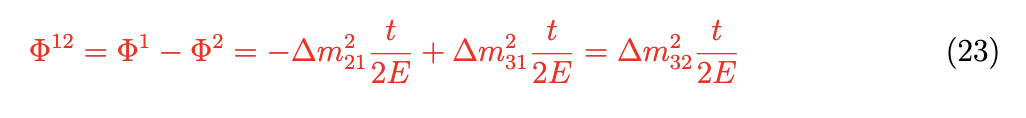
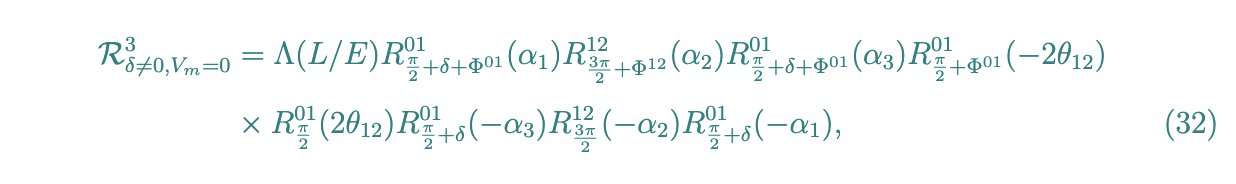

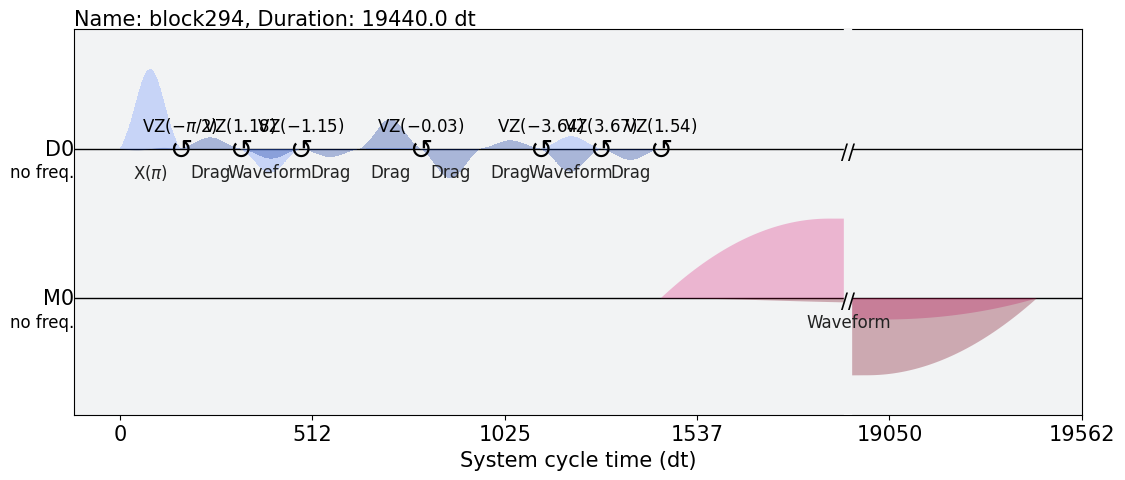

In [23]:
# June 6
matter = 0
t23m, t13m, t12m, D21m, D31m = parameters(matter)
c12m = cos(t12m)
s12m = sin(t12m)
c13m = cos(t13m)
s13m = sin(t13m)
c23m = cos(t23m)
s23m = sin(t23m)
dCP = 0#-pi/2#0#pi#0#-pi/2
conL = 5.06773
L = 295*conL
Emin = 0.01
Emax = 2

timestep = 297
Ereal = np.linspace(Emin,Emax,timestep)
# Lreal = np.linspace(Lmin,Lmax,timestep)
a2 = 2*np.arccos(cos(t13m)*cos(t23m))
a1 = -2*np.arccos(cos(t13m)*sin(t23m)/sin(a2/2))
a3 = 2*np.arccos(cos(a1/2)/cos(t13m))
schedules = [cal0, cal1, cal2]
for ii, E in enumerate(Ereal):
    phi0 = 3.05453053e-02
    phi2 = 9.74995554e-01
    c0 = 4.46980553e-04
    c2 = 2.76446327e-03
    l = L
    d2 = D21m*l/(2*E)
    d3 = D31m*l/(2*E)
    alpha = d2
    beta = -(d2-d3)
    with pulse.build(backend=backend, default_alignment="sequential") as neu_sched:
        ## PMNS dagger
        pulse.play(xp, drive_chan)        
        with pulse.phase_offset(pi/2 + dCP, drive_chan):
            rx01(-a1)
        phase2 = 2*phi2 + c2*(-a1+pi)
        with pulse.phase_offset((1.5*pi + phase2)%(2*pi) , drive_chan):
            rx12(-a2)
        phase0 = phi0 + c0*(-a2)
        with pulse.phase_offset((dCP+pi/2 - phase0)%(2*pi), drive_chan):
            rx01(-a3)
        with pulse.phase_offset((pi/2 - phase0)%(2*pi), drive_chan):
            rx01(2*t12m)
        ## evolution x PMNS
        with pulse.phase_offset((alpha+pi/2 - phase0)%(2*pi) , drive_chan):
            rx01(-2*t12m)
        with pulse.phase_offset((dCP+alpha+pi/2 - phase0)%(2*pi) , drive_chan):
            rx01(a3)
        phase2 = phi2*4+phase2
        with pulse.phase_offset((beta+1.5*pi + phase2)%(2*pi), drive_chan):
            rx12(a2)
        phase0 = phi0 + c0*(a2)+phase0
        with pulse.phase_offset((dCP+alpha+pi/2 - phase0)%(2*pi), drive_chan):
            rx01(a1)
        pulse.call(meas_sched)
    schedules.append(neu_sched)
schedules[-3].draw()

# KeyboardInterrupt 
# is for sending multiple jobs to IBMQ at once to retrieve the jobs later

In [44]:
#, schedule_los=[{drive_chan: f01}] * 100
shots = 1024*4
qobj = assemble(schedules, backend, meas_level=1, 
                meas_return=MeasReturnType.SINGLE,
                shots=shots, rep_delay=0.0005)
job = backend.run(qobj)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

62a051e3093325867238978d
Job Status: job is queued (21)    

KeyboardInterrupt: 

# Job ID 

In [ ]:
629dd2fda3847102cf452348 -pi/2
629dd459d624be2739c8be38
629dd469b675fc0faa17335b
629dd479a70e338b4760a513

In [ ]:
zero 629dd33fc62352edf39e31eb
629dd3fee66b1830084d25f7
629dd40c01885c0874f3639f
629dd428ba69a43a8d5e781f
62a051e3093325867238978d

In [ ]:
pi 629dd369a70e33c7b260a510
629dd392b675fc0e0c173356
629dd3a6a384711b0a45234e
629dd3bfa70e33578260a512

In [26]:
import time
time.ctime()

'Tue Jun  7 06:43:53 2022'

In [25]:
job = backend.retrieve_job('629dd479a70e338b4760a513')
job.status()
# job.queue_info()

<JobStatus.DONE: 'job has successfully run'>

# Readout and mitigation

In [26]:
shots = 4096
geom_result = job.result(timeout=600)
cal_result_disc = job.result(timeout=600)
# [cal0, cal1, cal2]
svc = SVC(C=0.01, kernel="rbf", gamma="scale")
svc_discriminator = SklearnIQDiscriminator(svc, geom_result, [0], ['0', '1', '10'])
filter012 = DiscriminationFilter(svc_discriminator)
# Apply discriminator
geom_discriminated = filter012.apply(geom_result)
cal_counts = filter012.apply(cal_result_disc).get_counts()
cal_matrix = np.array([[cal_counts[0].get('0',0), cal_counts[1].get('0',0), cal_counts[2].get('0',0)],
                       [cal_counts[0].get('1',0), cal_counts[1].get('1',0), cal_counts[2].get('1',0)],
                       [cal_counts[0].get('10',0), cal_counts[1].get('10',0), cal_counts[2].get('10',0)]])/shots
meas_filter = MeasurementFilter(cal_matrix, ['0', '1', '10'])
print(cal_matrix)
# Mitigate readout errors
geom_mitigated = meas_filter.apply(geom_discriminated)
# Compute the population counts
counts = geom_mitigated.get_counts()

[[0.94238281 0.07177734 0.00610352]
 [0.01538086 0.89379883 0.18530273]
 [0.04223633 0.03442383 0.80859375]]


In [57]:
# Jakarta's EJ/EC
Ec = f01 - f12
Ej = (2*f01-f12)**2/(8*(f01-f12))
print(f"Ej/Ec: {Ej/Ec:.2f}") # This value is typically ~ 30 

Ej/Ec: 33.65


In [1]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import pandas as pd
import seaborn as sns
#bodacious colors
colors=sns.color_palette("rocket",3)
#Ram's colors, if desired
seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608', '#0193b0', '#9c5300', '#949c01', '#7104b5']
#            0sangre,   1neptune,  2pumpkin,  3clover,   4denim,    5cocoa,    6cumin,    7berry

In [37]:
#Import
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
data_folder = Path('/Users/hanguyenc11/anaconda3/envs/Simulating_neutrino_oscillation_superconducting_qutrit_data/')

In [3]:
import pandas as pd
import seaborn as sns
#bodacious colors
colors=sns.color_palette("rocket",3)
#Ram's colors, if desired
seshadri = ['#c3121e', '#0348a1', '#ffb01c', '#027608', '#0193b0', '#9c5300', '#949c01', '#7104b5']
#            0sangre,   1neptune,  2pumpkin,  3clover,   4denim,    5cocoa,    6cumin,    7berry
def calculate_avg_err(data):
    """Calculate average value and standard deviation of data."""
    data_avg = []
    data_err = []

    # Find average and standard deviation of data
    for i in range(len(data[0])):
        temp = []
        for j in range(len(data)):
            temp.append(data[j][i])

        # Calculate average of each data point
        data_avg.append(np.average(temp))

        # Calculate standard deviation
        data_err.append(
            np.sqrt(
                np.sum([(data_avg[i] - val) ** 2 for val in temp])
                / len(temp)
            )
        )

    return data_avg, data_err


In [4]:
pi = np.pi
cos = np.cos
sin = np.sin
exp = np.exp
sqrt = np.sqrt
def Rx_01(theta):
    Rx_01 = np.array([[cos(theta/2)     , -1j*sin(theta/2) , 0],
                      [-1j*sin(theta/2) , cos(theta/2)     , 0],
                      [0                , 0                , 1]])
    return Rx_01

def Rx_12(theta):
    Rx_12 = np.array([[1 , 0                , 0               ],
                      [0 , cos(theta/2)     , -1j*sin(theta/2)],
                      [0 , -1j*sin(theta/2) , cos(theta/2)    ]])
    return Rx_12

def Ry_01(theta):
    Ry_01 = np.array([[cos(theta/2) , -sin(theta/2) , 0],
                      [sin(theta/2) , cos(theta/2)  , 0],
                      [0            , 0             , 1]])
    return Ry_01

def Ry_12(theta):
    Ry_12 = np.array([[1 , 0            , 0            ],
                      [0 , cos(theta/2) , -sin(theta/2)],
                      [0 , sin(theta/2) , cos(theta/2) ]])
    return Ry_12

def Rz_01(theta):
    Rz_01 = np.array([[exp((-1j*theta)/2) , 0                 , 0],
                      [0                  , exp((1j*theta)/2) , 0],
                      [0                  , 0                 , 1]])
    return Rz_01

def Rz_12(theta):
    Rz_12 = np.array([[1 , 0                  , 0                ],
                      [0 , exp((-1j*theta)/2) , 0                ],
                      [0 , 0                  , exp((1j*theta)/2)]])
    return Rz_12
t12 = np.radians(33.45)
t23 = np.radians(42.1)
t13 = np.radians(8.62)
D21 = 7.42*1e-5
D31 = 2.510*1e-3 
D32 = D31-D21 ###
# Now gate simulator
c12 = cos(t12)
s12 = sin(t12)
c13 = cos(t13)
s13 = sin(t13)
c23 = cos(t23)
s23 = sin(t23)

In [5]:
def parameters(a):
    Dee = c12**2*D31+s12**2*D32
    Dee_t = Dee*sqrt((cos(2*t13)-a/Dee)**2+sin(2*t13)**2)
    s13t_sq = 0.5*(1-(Dee*cos(2*t13)-a)/Dee_t)
    t13t = np.arcsin(sqrt(s13t_sq))
    a12 = 0.5*(a+Dee-Dee_t)
    D21t = D21*sqrt((cos(2*t12)-a12/D21)**2 + cos(t13-t13t)**2*sin(2*t12)**2)
    s12t_sq = 0.5*(1-(D21*cos(2*t12)-a12)/D21t)
    t12t = np.arcsin(sqrt(s12t_sq))
    D31t = D31+a/4+0.5*(D21t-D21)+0.75*(Dee_t-Dee)
    t23t = t23
    return t23t,t13t, t12t, D21t, D31t
def NeudCPMatter(dCP, initial, matter, sim):
    try:
        if initial == 'e':
            flavor_initial = [1,0,0]
        elif initial == 'm':
            flavor_initial = [0,1,0]
        elif initial == 't':
            flavor_initial = [0,0,1]
    except:
        print('start from e, m, t only')
    t23m, t13m, t12m, D21m, D31m = parameters(matter)
    dCPm = dCP
    c12m = cos(t12m)
    s12m = sin(t12m)
    c13m = cos(t13m)
    s13m = sin(t13m)
    c23m = cos(t23m)
    s23m = sin(t23m)
    
    Um = np.array([[c12m*c13m            , s12m*c13m             , s13m*exp(-1j*dCP)],
               [-s12m*c23m-c12m*s23m*s13m*exp(1j*dCP), c12m*c23m-s12m*s23m*s13m*exp(1j*dCP) , s23m*c13m],
               [s12m*s23m-c12m*c23m*s13m*exp(1j*dCP) , -c12m*s23m-s12m*c23m*s13m*exp(1j*dCP), c23m*c13m]])
    iUm = Um.conj().T

    e_survival1a = []
    mu_survival1a = []
    tau_survival1a = []
    conL = 5.06773
    for E in sim:
        l = L*conL
        evolmatrix = np.diag([1, exp(-1j*D21m*l/(2*E)), exp(-1j*l*D31m/(2*E))])
        flavor = Um@evolmatrix@iUm@flavor_initial
        e_survival1a.append(np.absolute(flavor[0])**2)
        mu_survival1a.append(np.absolute(flavor[1])**2)
        tau_survival1a.append(np.absolute(flavor[2])**2)
    return e_survival1a, mu_survival1a, tau_survival1a

In [40]:
data_z1 = np.loadtxt(data_folder/'fig5_dCP_zero_job1.txt')
data_z2 = np.loadtxt(data_folder/'fig5_dCP_zero_job2.txt')
data_z3 = np.loadtxt(data_folder/'fig5_dCP_zero_job3.txt')
data_z4 = np.loadtxt(data_folder/'fig5_dCP_zero_job4.txt')

data_p1 = np.loadtxt(data_folder/'fig5_dCP_pi_job1.txt')
data_p2 = np.loadtxt(data_folder/'fig5_dCP_pi_job2.txt')
data_p3 = np.loadtxt(data_folder/'fig5_dCP_pi_job3.txt')
data_p4 = np.loadtxt(data_folder/'fig5_dCP_pi_job4.txt')

data_ph1 = np.loadtxt(data_folder/'fig5_dCP_pihalf_job1.txt')
data_ph2 = np.loadtxt(data_folder/'fig5_dCP_pihalf_job2.txt')
data_ph3 = np.loadtxt(data_folder/'fig5_dCP_pihalf_job3.txt')
data_ph4 = np.loadtxt(data_folder/'fig5_dCP_pihalf_job4.txt')

data_mph1 = np.loadtxt(data_folder/'fig5_dCP_minuspihalf_job1.txt')
data_mph2 = np.loadtxt(data_folder/'fig5_dCP_minuspihalf_job2.txt')
data_mph3 = np.loadtxt(data_folder/'fig5_dCP_minuspihalf_job3.txt')
data_mph4 = np.loadtxt(data_folder/'fig5_dCP_minuspihalf_job4.txt')

In [41]:
data_ze = [data_z1[0], data_z2[0], data_z3[0], data_z4[0]]
data_zm = [data_z1[1], data_z2[1], data_z3[1], data_z4[1]]
data_zt = [data_z1[2], data_z2[2], data_z3[2], data_z4[2]]
ze_avg = calculate_avg_err(data_ze)[0]
zm_avg = calculate_avg_err(data_zm)[0]
zt_avg = calculate_avg_err(data_zt)[0]

In [42]:
data_pe = [data_p1[0], data_p2[0], data_p3[0], data_p4[0]]
data_phe = [data_ph1[0], data_ph2[0], data_ph3[0], data_ph4[0]]
data_mphe = [data_mph1[0], data_mph2[0], data_mph3[0], data_mph4[0]]

In [43]:
phe_avg = calculate_avg_err(data_pe)[0]
phe_avg = calculate_avg_err(data_phe)[0]
mphe_avg = calculate_avg_err(data_mphe)[0]

In [44]:
len(ze_avg)

297

In [45]:
timestep = 297
Emin = 0.01
Emax = 2
L = 295
x = np.linspace(Emin, Emax, timestep)
Esim = np.linspace(Emin, Emax, 10000)

## Plot probablilites numu to all flavor with delta=0

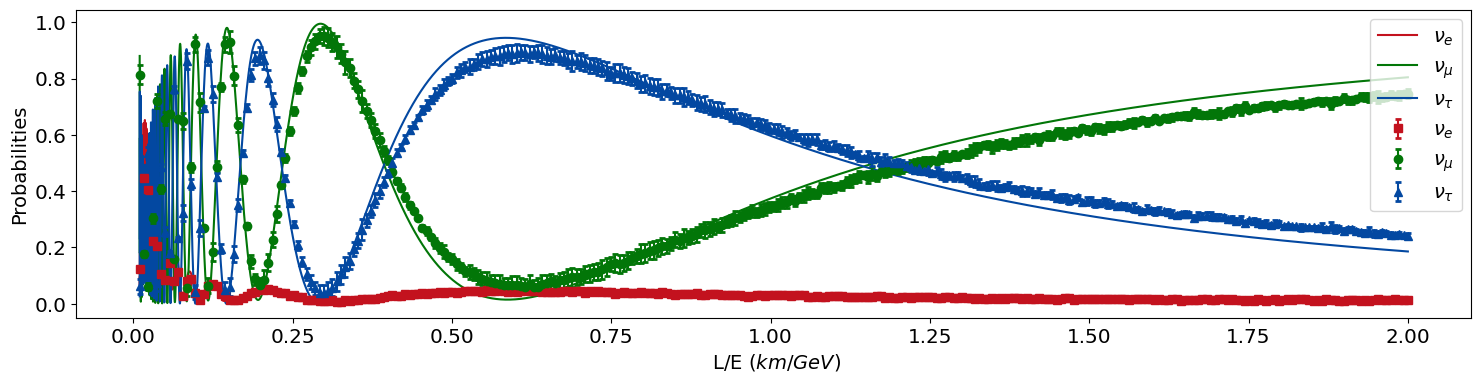

In [46]:
plt.figure(figsize=(18,4))
plt.xlabel(r' L/E ($km/GeV$)', fontsize=14) 
simulator = NeudCPMatter(dCP=0, initial='m', matter=0, sim=Esim)
e_survival1a, mu_survival1a, tau_survival1a = simulator[0], simulator[1], simulator[2]
plt.ylabel(r'Probabilities',fontsize=14)  # label the y axis

plt.plot(Esim,e_survival1a, color=seshadri[0], label=r'$\nu_e$')
plt.plot(Esim,mu_survival1a, c=seshadri[3], label=r'$\nu_\mu$')
plt.plot(Esim,tau_survival1a, c=seshadri[1], label=r'$\nu_\tau$')
plt.errorbar(x, ze_avg, yerr=calculate_avg_err(data_ze)[1],fmt="s", color=seshadri[0], capsize=2,capthick=2, label=r'$\nu_e$')
plt.errorbar(x, zm_avg, yerr=calculate_avg_err(data_zm)[1],fmt="o", color=seshadri[3], capsize=2,capthick=2, label=r'$\nu_\mu$')
plt.errorbar(x, zt_avg, yerr=calculate_avg_err(data_zt)[1],fmt="^",color=seshadri[1],  capsize=2,capthick=2, label=r'$\nu_\tau$')
plt.legend(fontsize=14)  # add the legend (will default to 'best' location)

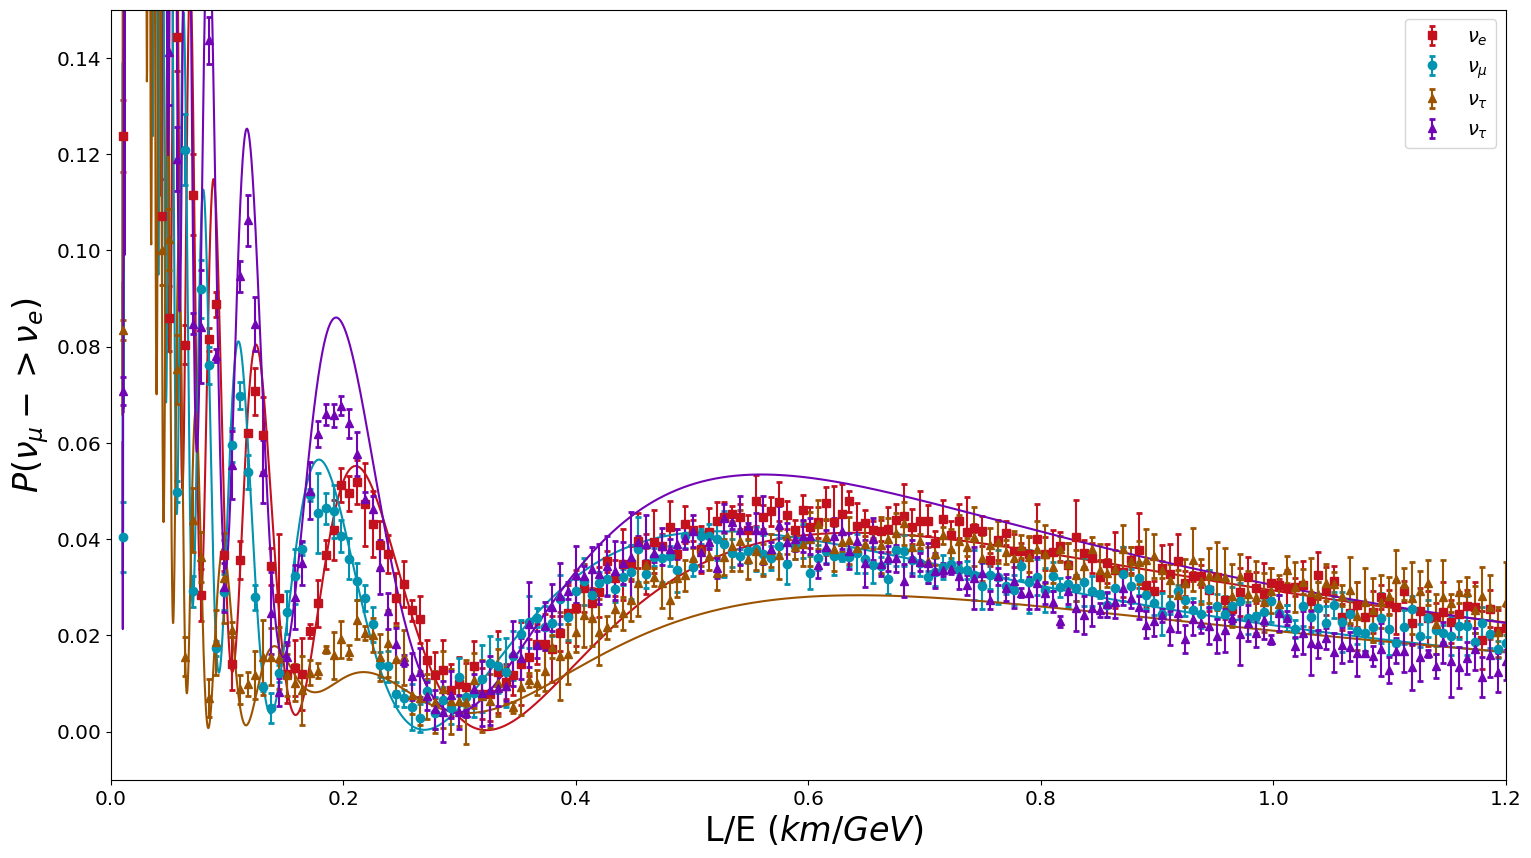

In [47]:
plt.figure(figsize=(18,10))
plt.xlabel(r' L/E ($km/GeV$)', fontsize=24) 
simulator = NeudCPMatter(dCP=0, initial='m', matter=0, sim=Esim)
e_survival1a, mu_survival1a, tau_survival1a = simulator[0], simulator[1], simulator[2]
plt.ylabel(r'$P(\nu_\mu -> \nu_e)$', fontsize=24)  # label the y axis
plt.plot(Esim, e_survival1a, color=seshadri[0])
plt.errorbar(x, ze_avg, yerr=calculate_avg_err(data_ze)[1],fmt="s", color=seshadri[0], capsize=2,capthick=2, label=r'$\nu_e$')
simulator = NeudCPMatter(dCP=pi, initial='m', matter=0, sim=Esim)
e_survival1a, mu_survival1a, tau_survival1a = simulator[0], simulator[1], simulator[2]
plt.plot(Esim, e_survival1a, color=seshadri[4])

plt.errorbar(x, pe_avg, yerr=calculate_avg_err(data_pe)[1],fmt="o", color=seshadri[4], capsize=2,capthick=2, label=r'$\nu_\mu$')
simulator = NeudCPMatter(dCP=pi/2, initial='m', matter=0, sim=Esim)
e_survival1a, mu_survival1a, tau_survival1a = simulator[0], simulator[1], simulator[2]
plt.plot(Esim, e_survival1a, color=seshadri[5])
 
plt.errorbar(x, phe_avg, yerr=calculate_avg_err(data_phe)[1],fmt="^",color=seshadri[5],  capsize=2,capthick=2, label=r'$\nu_\tau$')

simulator = NeudCPMatter(dCP=-pi/2, initial='m', matter=0, sim=Esim)
e_survival1a, mu_survival1a, tau_survival1a = simulator[0], simulator[1], simulator[2]
plt.plot(Esim, e_survival1a, color=seshadri[-1])

plt.errorbar(x, mphe_avg, yerr=calculate_avg_err(data_mphe)[1],fmt="^",color=seshadri[-1],  capsize=2,capthick=2, label=r'$\nu_\tau$')
plt.ylim(-0.01, 0.15)
plt.xlim(0, 1.2)
plt.legend(fontsize=14)  # add the legend (will default to 'best' location)


# R2 score

In [48]:
from sklearn.metrics import r2_score

In [49]:
# data delta=pi
data_pe = [data_p1[0], data_p2[0], data_p3[0], data_p4[0]]
data_pm = [data_p1[1], data_p2[1], data_p3[1], data_p4[1]]
data_pt = [data_p1[2], data_p2[2], data_p3[2], data_p4[2]]
pe_avg = calculate_avg_err(data_pe)[0]
pm_avg = calculate_avg_err(data_pm)[0]
pt_avg = calculate_avg_err(data_pt)[0]
# data delta=pi/2
data_phe = [data_ph1[0], data_ph2[0], data_ph3[0], data_ph4[0]]
data_phm = [data_ph1[1], data_ph2[1], data_ph3[1], data_ph4[1]]
data_pht = [data_ph1[2], data_ph2[2], data_ph3[2], data_ph4[2]]
phe_avg = calculate_avg_err(data_phe)[0]
phm_avg = calculate_avg_err(data_phm)[0]
pht_avg = calculate_avg_err(data_pht)[0]
# data delta=-pi/2
data_mphe = [data_mph1[0], data_mph2[0], data_mph3[0], data_mph4[0]]
data_mphm = [data_mph1[1], data_mph2[1], data_mph3[1], data_mph4[1]]
data_mpht = [data_mph1[2], data_mph2[2], data_mph3[2], data_mph4[2]]
mphe_avg = calculate_avg_err(data_mphe)[0]
mphm_avg = calculate_avg_err(data_mphm)[0]
mpht_avg = calculate_avg_err(data_mpht)[0]

In [50]:
simulator = NeudCPMatter(dCP=0, initial='m', matter=0, sim=x)
me_sim0, mm_sim0, mt_sim0 = simulator[0], simulator[1], simulator[2]
r2_me0 = r2_score(ze_avg, me_sim0)
r2_mm0 = r2_score(zm_avg, mm_sim0)
r2_mt0 = r2_score(zt_avg, mt_sim0)
print(r2_me0, r2_mm0, r2_mt0)
simulator = NeudCPMatter(dCP=pi, initial='m', matter=0, sim=x)
me_simp, mm_simp, mt_simp = simulator[0], simulator[1], simulator[2]
r2_mep = r2_score(pe_avg, me_simp)
r2_mmp = r2_score(pm_avg, mm_simp)
r2_mtp = r2_score(pt_avg, mt_simp)
print(r2_mep, r2_mmp, r2_mtp)
simulator = NeudCPMatter(dCP=pi/2, initial='m', matter=0, sim=x)
me_simph, mm_simph, mt_simph = simulator[0], simulator[1], simulator[2]
r2_meph = r2_score(phe_avg, me_simph)
r2_mmph = r2_score(phm_avg, mm_simph)
r2_mtph = r2_score(pht_avg, mt_simph)
print(r2_meph, r2_mmph, r2_mtph)
simulator = NeudCPMatter(dCP=-pi/2, initial='m', matter=0, sim=x)
me_simmph, mm_simmph, mt_simmph = simulator[0], simulator[1], simulator[2]
r2_memph = r2_score(mphe_avg, me_simmph)
r2_mmmph = r2_score(mphm_avg, mm_simmph)
r2_mtmph = r2_score(mpht_avg, mt_simmph)
print(r2_memph, r2_mmmph, r2_mtmph)

0.9800594680543259 0.9639554662623849 0.9590361117959489
0.9882718331181765 0.9714207227715934 0.9739613613861183
0.9237823207818161 0.9631854363171187 0.9663637231605606
0.9672265647483776 0.9552242690878646 0.9465366270231954
